In [1]:
import os
import cv2
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score
from keras import optimizers
from keras import backend as K
from keras.models import Sequential, Model
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/imet-2019-fgvc6/train.csv')
labels = pd.read_csv('../input/imet-2019-fgvc6/labels.csv')
test = pd.read_csv('../input/imet-2019-fgvc6/sample_submission.csv')

train["attribute_ids"] = train["attribute_ids"].apply(lambda x:x.split(" "))
train["id"] = train["id"].apply(lambda x: x + ".png")
test["id"] = test["id"].apply(lambda x: x + ".png")

print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
print('Number of labels: ', labels.shape[0])
display(train.head())
display(labels.head())

Number of train samples:  109237
Number of test samples:  7443
Number of labels:  1103


,id,attribute_ids
0,1000483014d91860.png,"[147, 616, 813]"
1,1000fe2e667721fe.png,"[51, 616, 734, 813]"
2,1001614cb89646ee.png,[776]
3,10041eb49b297c08.png,"[51, 671, 698, 813, 1092]"
4,100501c227f8beea.png,"[13, 404, 492, 903, 1093]"


,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


### Model parameters

In [3]:
# Model parameters
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.0001
HEIGHT = 64
WIDTH = 64
CANAL = 3
N_CLASSES = labels.shape[0]
ES_PATIENCE = 15
DECAY_DROP = 0.5
DECAY_EPOCHS = 10
classes = list(map(str, range(N_CLASSES)))

In [4]:
def f2_score_thr(threshold=0.5):
    def f2_score(y_true, y_pred):
        beta = 2
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())

        true_positives = K.sum(K.clip(y_true * y_pred, 0, 1), axis=1)
        predicted_positives = K.sum(K.clip(y_pred, 0, 1), axis=1)
        possible_positives = K.sum(K.clip(y_true, 0, 1), axis=1)

        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())

        return K.mean(((1+beta**2)*precision*recall) / ((beta**2)*precision+recall+K.epsilon()))
    return f2_score


def custom_f2(y_true, y_pred):
    beta = 2

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = (1+beta**2)*p*r / (p*beta**2 + r + 1e-15)

    return f2

def step_decay(epoch):
    initial_lrate = LEARNING_RATE
    drop = DECAY_DROP
    epochs_drop = DECAY_EPOCHS
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lrate

In [5]:
train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/imet-2019-fgvc6/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
    classes=classes,
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/imet-2019-fgvc6/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",    
    classes=classes,
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/imet-2019-fgvc6/test",    
        x_col="id",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 81928 images belonging to 1103 classes.
Found 27309 images belonging to 1103 classes.
Found 7443 images.


### Model

In [6]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.DenseNet169(weights=None, include_top=False,
                   input_tensor=input_tensor)
    base_model.load_weights('../input/densenet-keras/DenseNet-BC-169-32-no-top.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='sigmoid', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [7]:
# warm up model
# first: train only the top layers (which were randomly initialized)
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5,0):
    model.layers[i].trainable = True
    
optimizer = optimizers.Adam(lr=LEARNING_RATE)
metrics = ["accuracy", "categorical_accuracy"]
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=ES_PATIENCE)
callbacks = [es]
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metrics)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormal

#### Train top layers

In [8]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callbacks,
                              verbose=2,
                              max_queue_size=16, workers=3, use_multiprocessing=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 554s - loss: 0.0360 - acc: 0.9898 - categorical_accuracy: 0.0396 - val_loss: 0.0175 - val_acc: 0.9971 - val_categorical_accuracy: 0.0608
Epoch 2/30
 - 536s - loss: 0.0166 - acc: 0.9970 - categorical_accuracy: 0.0699 - val_loss: 0.0175 - val_acc: 0.9971 - val_categorical_accuracy: 0.0446
Epoch 3/30
 - 537s - loss: 0.0151 - acc: 0.9971 - categorical_accuracy: 0.0826 - val_loss: 0.0170 - val_acc: 0.9971 - val_categorical_accuracy: 0.0633
Epoch 4/30
 - 528s - loss: 0.0144 - acc: 0.9971 - categorical_accuracy: 0.0923 - val_loss: 0.0163 - val_acc: 0.9971 - val_categorical_accuracy: 0.0761
Epoch 5/30
 - 535s - loss: 0.0140 - acc: 0.9972 - categorical_accuracy: 0.0935 - val_loss: 0.0158 - val_acc: 0.9971 - val_categorical_accuracy: 0.0694
Epoch 6/30
 - 537s - loss: 0.0137 - acc: 0.9971 - categorical_accuracy: 0.0960 - val_loss: 0.0154 - val_acc: 0.9971 - val_categorical_accuracy: 0.0632
Epoch 7/30
 - 524s - loss: 0.0133 - acc: 0.997

#### Fine-tune the complete model

In [9]:
for i in range(-14, 0):
    model.layers[i].trainable = True

metrics = ["accuracy", "categorical_accuracy"]
lrate = LearningRateScheduler(step_decay)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=(ES_PATIENCE))
callbacks = [es, lrate]
optimizer = optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metrics)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [10]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callbacks,
                              verbose=2,
                              max_queue_size=16, workers=3, use_multiprocessing=True)

Epoch 1/30
 - 558s - loss: 0.0121 - acc: 0.9972 - categorical_accuracy: 0.1200 - val_loss: 0.0141 - val_acc: 0.9971 - val_categorical_accuracy: 0.0779
Epoch 2/30
 - 547s - loss: 0.0120 - acc: 0.9972 - categorical_accuracy: 0.1237 - val_loss: 0.0141 - val_acc: 0.9971 - val_categorical_accuracy: 0.0776
Epoch 3/30
 - 548s - loss: 0.0120 - acc: 0.9972 - categorical_accuracy: 0.1226 - val_loss: 0.0141 - val_acc: 0.9971 - val_categorical_accuracy: 0.0780
Epoch 4/30
 - 540s - loss: 0.0120 - acc: 0.9972 - categorical_accuracy: 0.1225 - val_loss: 0.0141 - val_acc: 0.9971 - val_categorical_accuracy: 0.0769
Epoch 5/30
 - 548s - loss: 0.0120 - acc: 0.9972 - categorical_accuracy: 0.1260 - val_loss: 0.0140 - val_acc: 0.9971 - val_categorical_accuracy: 0.0797
Epoch 6/30
 - 545s - loss: 0.0121 - acc: 0.9972 - categorical_accuracy: 0.1244 - val_loss: 0.0142 - val_acc: 0.9971 - val_categorical_accuracy: 0.0768
Epoch 7/30
 - 537s - loss: 0.0120 - acc: 0.9972 - categorical_accuracy: 0.1220 - val_loss: 0.0

### Complete model graph loss

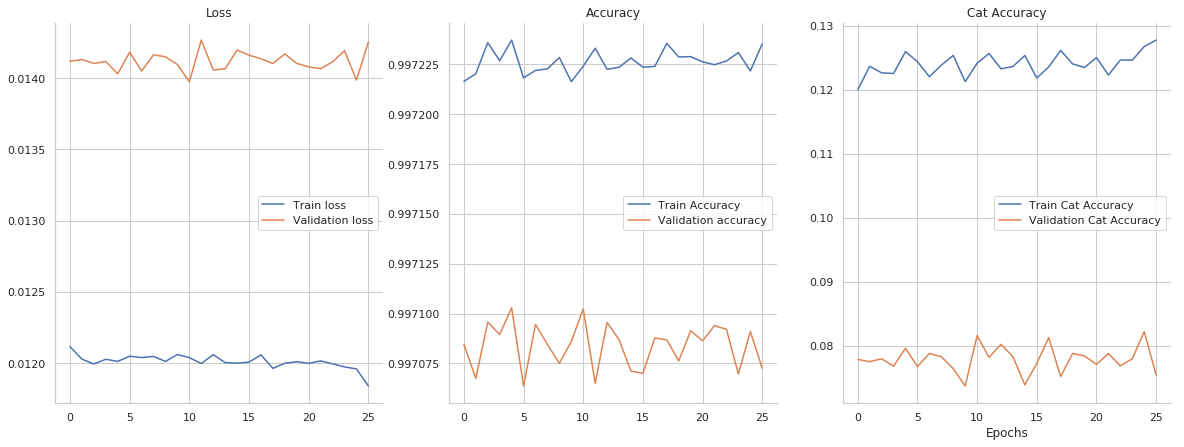

In [11]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(20,7))


ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['acc'], label='Train Accuracy')
ax2.plot(history.history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

ax3.plot(history.history['categorical_accuracy'], label='Train Cat Accuracy')
ax3.plot(history.history['val_categorical_accuracy'], label='Validation Cat Accuracy')
ax3.legend(loc='best')
ax3.set_title('Cat Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

### Find best threshold value

In [12]:
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    
print(lastFullValPred.shape, lastFullValLabels.shape)

(27309, 1103) (27309, 1103)


thr=0.090 F2=0.270


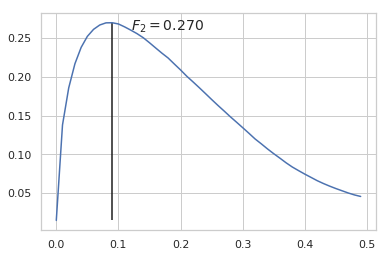

In [13]:
def find_best_fixed_threshold(preds, targs, do_plot=True):
    score = []
    thrs = np.arange(0, 0.5, 0.01)
    for thr in thrs:
        score.append(custom_f2(targs, (preds > thr).astype(int)))
    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
    if do_plot:
        plt.plot(thrs, score)
        plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
        plt.text(best_thr+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
        plt.show()
    return best_thr, best_score

threshold, best_score = find_best_fixed_threshold(lastFullValPred, lastFullValLabels, do_plot=True)

### Apply model to test set and output predictions

In [14]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)

In [15]:
predictions = []
for pred_ar in preds:
    valid = []
    for idx, pred in enumerate(pred_ar):
        if pred > threshold:
            valid.append(idx)
    if len(valid) == 0:
        valid.append(np.argmax(pred_ar))
    predictions.append(valid)

In [16]:
filenames = test_generator.filenames
label_map = {valid_generator.class_indices[k] : k for k in valid_generator.class_indices}

results = pd.DataFrame({'id':filenames, 'attribute_ids':predictions})
results['id'] = results['id'].map(lambda x: str(x)[:-4])
results['attribute_ids'] = results['attribute_ids'].apply(lambda x: list(map(label_map.get, x)))
results["attribute_ids"] = results["attribute_ids"].apply(lambda x: ' '.join(x))
results.to_csv('submission.csv',index=False)
results.head(10)

,id,attribute_ids
0,10023b2cc4ed5f68,121 147 369 464 493 634 754 840 872
1,100fbe75ed8fd887,1059 1092 121 147 369 612 671 724 744 79 811 8...
2,101b627524a04f19,1092 147 671 813
3,10234480c41284c6,1046 1092 13 147 189 51 671 813 896
4,1023b0e2636dcea8,1030 1046 1059 1080 1092 147 154 156 212 227 2...
5,1039cd6cf85845c,1092 147 156 189 405 51 554 744 813 835 896 903
6,103a5b3f83fbe88,1092 13 147 194 51 671 813 896 952
7,10413aaae8d6a9a2,1046 1092 13 147 156 189 51 813 835 896
8,10423822b93a65ab,1034 1092 147 189 434 671 780 79 813
9,1052bf702cb099f7,1059 1092 147 156 51 612 671 780 813
